# Figures and tables for manuscript
Created by Ivan Lima on Thu Jan 21 2021 10:27:14 -0500

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
import warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Sun Jan 31 19:20:43 2021


In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50

## Read NSF-OCE award data

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year

npzfile = np.load('results/NMF_TSNE.npz')
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
npzfile.close()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER seems to be an older denomination for EAGER awards. Therefore we are grouping these two types of awards together as EAGER awards.

In [4]:
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

## Temporal trends in gender composition

The temporal trend for female PIs has a smaller slope than that of co-PIs and workforce but the difference is not statistically significant.

,R^2,slope,p-value
PI,0.878,0.598,0.000000
co-PI,0.804,0.675,0.000000
workforce,0.994,0.688,0.000000


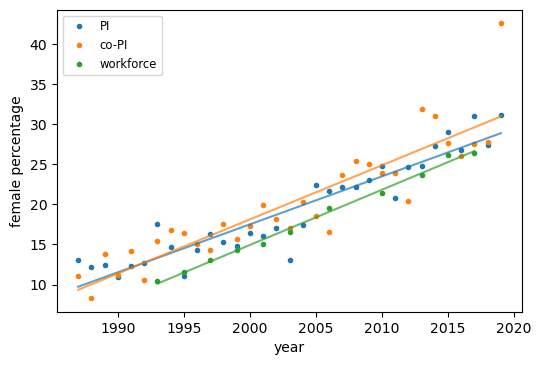

In [5]:
# female & male fraction of PIs
pi_gender = awards.groupby([awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0) * 100 # fraction -> percentage

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].mean()})
copi_gender['male'] = 1 - copi_gender.female
copi_gender = copi_gender * 100 # fraction -> percentage

# female percentage of PIs & co-PIs
female_pct = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
female_pct.index.rename('year',inplace=True)

f_error = lambda x: 1.96 * x.std()/np.sqrt(x.size)
error = awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].apply(f_error)

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, ax = plt.subplots()

_ = female_pct.PI.plot(ax=ax, style='C0.')
_ = female_pct['co-PI'].plot(ax=ax, style='C1.')
_ = workforce.plot(x='year', y='female_pct', ax=ax, style='C2.', legend=False)
_ = ax.set(ylabel='female percentage')
_ = ax.legend(['PI','co-PI','workforce'])

params = []
for x, y, s in zip([female_pct.index, female_pct.index, workforce.year],
                   [female_pct.PI, female_pct['co-PI'], workforce.female_pct],['C0-','C1-','C2-']):
    reg, X = linreg(x, y)
    params.append([reg.rsquared,reg.params[1],reg.pvalues[1]])
    _ = ax.plot(x, reg.predict(X), s, alpha=0.7)

fig.savefig('figures/pi_copi_workforce_regress.png',dpi=300,bbox_inches='tight')

lr_stats = pd.DataFrame(np.array(params), index=['PI','co-PI','workforce'],
                        columns=['R^2','slope','p-value'])
lr_stats.style.format('{:.3f}', subset=['R^2','slope'])

## Gender composition across top 10 programs

The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each program. A ratio greater than one means female PIs have a larger percentage of awards in that program than male PIs, and vice-versa. The dotted line represents the 1:1 ratio.

1987-1997                        1998-2008  \
                                       PI      co-PI freq_ratio         PI   
program                                                                      
MARINE GEOLOGY AND GEOPHYSICS   13.835198  12.667474   1.048144  18.777293   
BIOLOGICAL OCEANOGRAPHY         20.323326  20.978513   1.665056  22.378717   
PHYSICAL OCEANOGRAPHY           10.256410  11.008230   0.746032  16.504854   
CHEMICAL OCEANOGRAPHY           11.401425  14.367816   0.840036  18.082789   
OCEAN TECH & INTERDISC COORDIN   6.741573  25.980392   0.471888  11.675127   
OCEANOGRAPHIC INSTRUMENTATION    1.898734  13.586957   0.126344   4.938272   
SHIPBOARD SCIENTIFIC SUPP EQUI   5.095541   0.000000   0.350485   2.941176   
OCEAN DRILLING PROGRAM          12.931034   6.250000   0.969472  11.881188   
EDUCATION/HUMAN RESOURCES       13.636364  39.393939   1.030702  31.192661   
MAJOR RESEARCH INSTRUMENTATION  11.111111  10.000000   0.815972  11.956522   

                                                      2009-2019             \
                                    co-PI freq_ratio         PI      co-PI   
program                                                                      
MARINE GEOLOGY AND GEOPHYSICS   17.456940   1.107881  26.656627  27.476377   
BIOLOGICAL OCEANOGRAPHY         20.989011   1.381631  32.998325  33.125000   
PHYSICAL OCEANOGRAPHY           16.264802   0.947301  20.825147  23.902233   
CHEMICAL OCEANOGRAPHY           23.886494   1.057859  24.618736  27.244766   
OCEAN TECH & INTERDISC COORDIN  19.820513   0.633456  20.000000   8.720401   
OCEANOGRAPHIC INSTRUMENTATION    5.026455   0.248947   4.511278  12.554113   
SHIPBOARD SCIENTIFIC SUPP EQUI   0.606061   0.145219   3.614458   5.263158   
OCEAN DRILLING PROGRAM          17.785714   0.646143  26.984127  21.896552   
EDUCATION/HUMAN RESOURCES       61.111111   2.172477  51.851852  55.067568   
MAJOR RESEARCH INSTRUMENTATION  15.610329   0.650797  21.428571  19.494048   

                                           
                               freq_ratio  
program                                    
MARINE GEOLOGY AND GEOPHYSICS    1.071852  
BIOLOGICAL OCEANOGRAPHY          1.452435  
PHYSICAL OCEANOGRAPHY            0.775695  
CHEMICAL OCEANOGRAPHY            0.963147  
OCEAN TECH & INTERDISC COORDIN   0.737276  
OCEANOGRAPHIC INSTRUMENTATION    0.139328  
SHIPBOARD SCIENTIFIC SUPP EQUI   0.110591  
OCEAN DRILLING PROGRAM           1.089887  
EDUCATION/HUMAN RESOURCES        3.175960  
MAJOR RESEARCH INSTRUMENTATION   0.804302

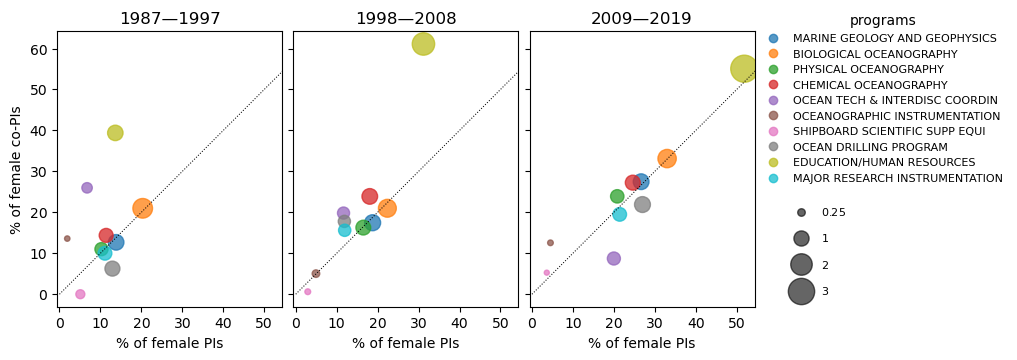

In [6]:
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
top10_programs = pd.DataFrame({'number of awards':
                               awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})

awards_top10 = awards[awards.program.isin(top10_programs.index)] # awards in top 10 programs

awards_top10_1 = awards_top10[awards_top10.year<1998]                              # 1987-1997
awards_top10_2 = awards_top10[(awards_top10.year>1997) & (awards_top10.year<2009)] # 1998-2008
awards_top10_3 = awards_top10[awards_top10.year>2008]                              # 2009-2019 

def compute_pcts(df, grpvar):
    df_work_pi = df.groupby([grpvar,'PI_gender'])['Abstract'].count().unstack().fillna(0)
    # relative frequency distribution of NSF programs by PI gender
    df_freq = df_work_pi/df_work_pi.sum() * 100 # fraction -> percentage
    # PI gender percentage in the top 10 programs
    df_pi = df_work_pi.divide(df_work_pi.sum(axis=1), axis=0) * 100 # fraction -> percentage
    # co-PI gender percentage in the top 10 programs
    df_copi = pd.DataFrame({'female': df.groupby([grpvar])['co-PI_female_frac'].mean()})
    df_copi = df_copi.fillna(0) * 100 # fraction -> percentage
    return pd.DataFrame({'PI': df_pi.female,'co-PI':df_copi.female,'freq_ratio': df_freq.female/df_freq.male})

by_prog1 = compute_pcts(awards_top10_1,'program').reindex(top10_programs.index)
by_prog2 = compute_pcts(awards_top10_2,'program').reindex(top10_programs.index)
by_prog3 = compute_pcts(awards_top10_3,'program').reindex(top10_programs.index)

by_prog1['color'] = np.arange(len(by_prog1))
by_prog2['color'] = np.arange(len(by_prog2))
by_prog3['color'] = np.arange(len(by_prog3))

titles = [u'1987\u20141997',u'1998\u20142008',u'2009\u20142019']

splist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(),[by_prog1,by_prog2,by_prog3], titles):
    sp = ax.scatter(df['PI'], df['co-PI'], c=df['color'], s=df.freq_ratio*120, cmap=plt.cm.tab10, alpha=0.75)
    _ = ax.axis('scaled')
    _ = ax.set(xlabel='% of female PIs', title=t, xticks=np.arange(0,60,10))
    splist.append(sp)

_ = axs[0].set(ylabel='% of female co-PIs')
ymin, ymax = axs[0].get_ylim()
for ax in axs:
    _ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

labels1 = [p for p in by_prog1.index]
handles1, foo = sp.legend_elements()
l1 = ax.legend(handles1, labels1 ,loc="upper right", bbox_to_anchor=(2.15, 1.1), title='programs', fontsize=8, frameon=False)
_ = ax.add_artist(l1)

handles2, labels2 = sp.legend_elements(prop='sizes', num=[30,120,240,360], alpha=0.6)
labels2 = ['$\\mathdefault{0.25}$','$\\mathdefault{1}$','$\\mathdefault{2}$','$\\mathdefault{3}$']
l2 = ax.legend(handles2, labels2, loc='lower right', bbox_to_anchor=(1.45, 0), fontsize=8, frameon=False, labelspacing=1.3)

fig.savefig('figures/pi_copi_program_bubble.png',dpi=300,bbox_inches='tight')

cols = ['PI','co-PI','freq_ratio']
pd.concat([by_prog1[cols], by_prog2[cols], by_prog3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1)

## Gender composition across research topics

The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each topic. A ratio greater than one means female PIs have a larger percentage of awards in that topic than male PIs, and vice-versa. The dotted line represents the 1:1 ratio.

1987-1997                        1998-2008                        \
              PI      co-PI freq_ratio         PI      co-PI freq_ratio   
topic                                                                     
1      10.169492   5.555556   0.727260  16.666667   8.941176   0.916667   
2       5.590062   0.000000   0.380376   4.166667   0.694444   0.199275   
3       8.108108   6.944444   0.566835   4.090909   8.188406   0.195498   
4      12.052117   8.093525   0.880344  15.789474  13.470982   0.859375   
5      11.299435   6.153846   0.818361   9.051724   9.096692   0.456161   
6      22.743682  18.300654   1.891216  23.012552  19.173028   1.370018   
7      17.283951  27.500000   1.342356  30.263158  18.333333   1.988994   
8      16.371681   9.090909   1.257634  32.183908  30.598399   2.175141   
9      17.777778  15.625000   1.389001  21.126761  19.498654   1.227679   
10     11.111111  23.958333   0.803016  21.122112  19.507937   1.227336   
11     19.148936  15.811966   1.521505  24.293785  24.797735   1.470771   
12      4.780876   8.854167   0.322551  10.188679  13.348831   0.519958   
13     10.249307  16.598361   0.733620  19.745223  29.150702   1.127646   
14      6.521739  11.372549   0.448195  15.328467  20.104167   0.829741   
15     14.285714  15.000000   1.070689  11.627907  19.770723   0.603070   
16      6.707317   5.454545   0.461866   6.250000   6.000000   0.305556   
17     14.084507  31.240981   1.053136  25.196850  50.333333   1.543860   
18     23.846154  27.949438   2.011597  28.979592  24.237473   1.870211   
19     13.917526   9.365942   1.038632  16.666667  16.856743   0.916667   
20     14.733542  14.011799   1.110052  14.903846  23.115079   0.802731   
21     23.076923  21.212121   1.927239  21.904762  23.322851   1.285569   
22     11.464968  12.598039   0.831902  16.042781  15.397436   0.875796   

       2009-2019                        
              PI      co-PI freq_ratio  
topic                                   
1      34.482759   6.250000   1.496182  
2      14.285714   0.000000   0.473791  
3       3.463203  13.695090   0.101982  
4      20.740741  18.750000   0.743896  
5      14.285714  15.163170   0.473791  
6      28.481013  29.028486   1.132067  
7      35.000000  38.140351   1.530710  
8      40.944882  43.115416   1.970971  
9      28.571429  34.040060   1.137099  
10     31.111111  32.578836   1.283821  
11     19.658120  21.557143   0.695566  
12     18.644068  14.990817   0.651463  
13     32.307692  43.263889   1.356765  
14     13.846154  21.458333   0.456870  
15     26.470588  29.700855   1.023389  
16      3.883495  11.111111   0.114858  
17     43.624161  45.462046   2.199744  
18     37.666667  31.250000   1.717809  
19     25.490196  31.133702   0.972519  
20     22.857143  24.901961   0.842295  
21     36.697248  32.191781   1.647969  
22     25.961538  22.610139   0.996807

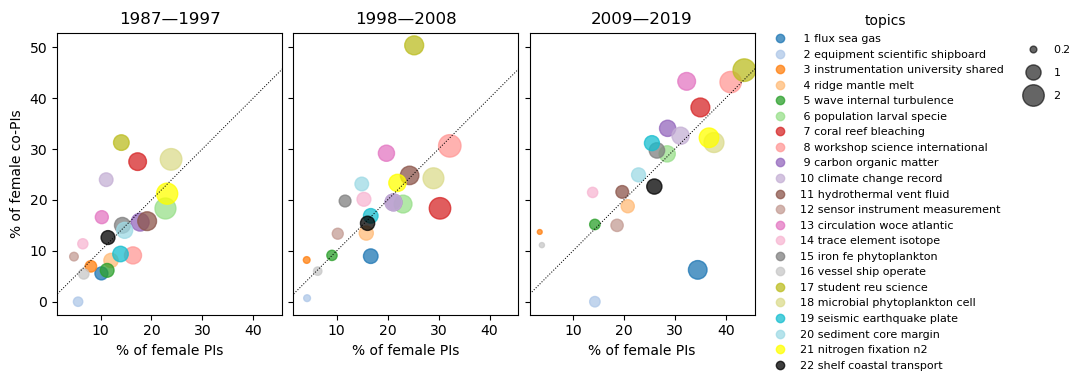

In [7]:
from matplotlib.colors import ListedColormap

tab20 = plt.cm.get_cmap('tab20')
newcmap = tab20.colors + ((1,1,0.0),) + ((0,0,0),)
tab22 = ListedColormap(newcmap,'tab22')

awards_1 = awards[awards.year<1998]                        # 1987-1997
awards_2 = awards[(awards.year>1997) & (awards.year<2009)] # 1998-2008
awards_3 = awards[awards.year>2008]                        # 2009-2019

by_topic_1 = compute_pcts(awards_1,'topic')
by_topic_2 = compute_pcts(awards_2,'topic')
by_topic_3 = compute_pcts(awards_3,'topic')

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(),[by_topic_1,by_topic_2,by_topic_3], titles):
    sp = ax.scatter(df['PI'], df['co-PI'], c=df.index, s=df.freq_ratio*120, cmap=tab22, alpha=0.75)
    _ = ax.axis('scaled')
    _ = ax.set(xlabel='% of female PIs', title=t)#, xticks=np.arange(0,60,10))

_ = axs[0].set(ylabel='% of female co-PIs')
ymin, ymax = axs[0].get_ylim()
for ax in axs:
    _ = ax.plot([0,ymax],[0,ymax],':',color='k',linewidth=0.75)

handles, foo = sp.legend_elements(num=len(by_topic_1))
l1 = ax.legend(handles, topic_names_r ,loc="upper right", bbox_to_anchor=(2.15, 1.1), title='topics', fontsize=8, frameon=False)
_ = ax.add_artist(l1)

handles2, labels2 = sp.legend_elements(prop='sizes', num=[24,120,240], alpha=0.6)
labels2 = ['$\\mathdefault{0.2}$','$\\mathdefault{1}$','$\\mathdefault{2}$']
l2 = ax.legend(handles2, labels2, loc='upper right', bbox_to_anchor=(2.45, 1), fontsize=8, frameon=False, labelspacing=1)

fig.savefig('figures/pi_copi_topic_bubble.png',dpi=300,bbox_inches='tight')

pd.concat([by_topic_1[cols], by_topic_2[cols], by_topic_3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1)

## Gender composition across award types

The size of the bubble corresponds to the ratio between the percentage of awards from female and male PIs in each award type. A ratio greater than one means female PIs have a larger percentage of awards in that award type than male PIs, and vice-versa. The dotted line represents the 1:1 ratio.

1987-1997                         1998-2008  \
                                PI      co-PI freq_ratio          PI   
standard                 13.251701  13.285843   0.981353   16.451494   
Collaborative Research   17.931034  11.847390   1.403592   20.518868   
EAGER                     9.756098  20.238095   0.694501   21.111111   
RAPID                     0.000000  21.428571   0.000000    0.000000   
REU                      14.851485  23.412698   1.120488   25.581395   
CAREER                   50.000000   0.000000   6.424132   20.512821   
RUI                      11.111111  25.000000   0.803016   33.333333   
CMG                       0.000000   0.000000   0.000000    0.000000   
POWRE                   100.000000   0.000000        inf  100.000000   

                                              2009-2019                        
                            co-PI freq_ratio         PI      co-PI freq_ratio  
standard                17.204356   0.902502  23.950617  23.922256   0.895281  
Collaborative Research  19.629722   1.183234  25.675676  27.980695   0.982040  
EAGER                   31.538462   1.226526  35.714286  37.121212   1.579304  
RAPID                   25.666667   0.000000  29.302326  30.449275   1.178244  
REU                     61.111111   1.575521  46.739130  52.083333   2.494655  
CAREER                   0.000000   1.182796  40.677966  87.500000   1.949312  
RUI                     21.666667   2.291667  39.285714  34.523810   1.839424  
CMG                     30.000000   0.000000   0.000000  25.000000   0.000000  
POWRE                    0.000000        inf        NaN        NaN        NaN

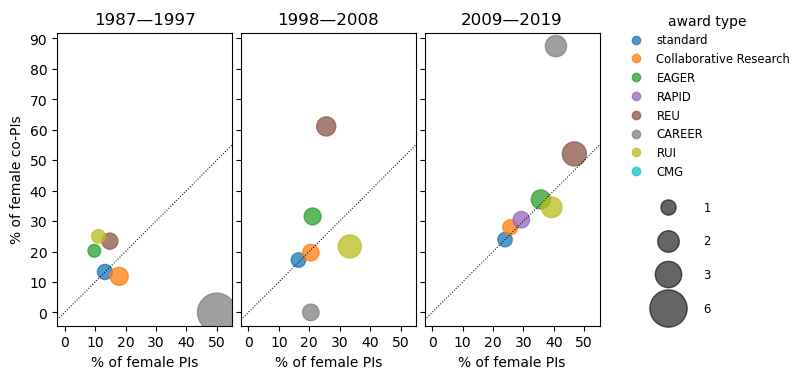

In [8]:
atypes = pd.DataFrame({'number of awards': awards.award_type.value_counts()}) # number of awards in each type

by_atype_1 = compute_pcts(awards_1,'award_type')
by_atype_2 = compute_pcts(awards_2,'award_type')
by_atype_3 = compute_pcts(awards_3,'award_type')

by_atype_1 = by_atype_1.reindex(atypes.index).fillna(0)
by_atype_2 = by_atype_2.reindex(atypes.index)
by_atype_3 = by_atype_3.reindex(atypes.index)

by_atype_1['color'] = np.arange(len(by_atype_1))
by_atype_2['color'] = np.arange(len(by_atype_2))
by_atype_3['color'] = np.arange(len(by_atype_3))

splist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(),[by_atype_1,by_atype_2,by_atype_3], titles):
    df = df.drop('POWRE')
    sp = ax.scatter(df['PI'], df['co-PI'], c=df.color, s=df.freq_ratio*120, cmap=plt.cm.tab10, alpha=0.75)
    _ = ax.axis('scaled')
    xmin, xmax = ax.get_xlim()
    _ = ax.set(xlim=(xmin,55), xlabel='% of female PIs', title=t, xticks=np.arange(0,60,10), yticks=np.arange(0,100,10))
    splist.append(sp)

_ = axs[0].set(ylabel='% of female co-PIs')
ymin, ymax = axs[0].get_ylim()
for ax in axs:
    _ = ax.plot([ymin,ymax],[ymin,ymax],':',color='k',linewidth=0.75)

handles1, foo = sp.legend_elements()
l1 = ax.legend(handles1, by_atype_1.index ,loc="upper right", bbox_to_anchor=(2.15, 1.1), title='award type', frameon=False)
_ = ax.add_artist(l1)

handles2, labels2 = splist[0].legend_elements(prop='sizes', num=[120, 240, 360, 720], alpha=0.6)
labels2 = ['$\\mathdefault{1}$','$\\mathdefault{2}$','$\\mathdefault{3}$','$\\mathdefault{6}$']
l2 = ax.legend(handles2, labels2, loc='lower right', bbox_to_anchor=(1.7, 0), frameon=False, labelspacing=1.8, handletextpad=2)

fig.savefig('figures/pi_copi_atype_bubble.png',dpi=300,bbox_inches='tight')

pd.concat([by_atype_1[cols], by_atype_2[cols], by_atype_3[cols]], keys=['1987-1997','1998-2008', '2009-2019'], axis=1)